In [1]:
import pymc3 as pm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import missingno as msno
from sklearn.preprocessing import LabelEncoder
import theano.tensor as tt
from utils import ECDF
import arviz as az

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Introduction

This notebook is designed to give you more practice with PyMC3 syntax. 

It is intentionally designed to provide more guidance w.r.t. model definition, i.e. which parameters to use, such that the focus is more on PyMC3 syntax rather than the mechanics of model definition. 

If you are already feeling comfortable with PyMC3 syntax, and would like to instead move on to practice with model definition, then feel free to move onto notebook 5 instead, where you can play with the Darwin's Finches dataset. That notebook is intentionally designed with much more freedom.

## Setup

You will be experimentally analyzing the effectiveness of six different phone sterilization methods against two control methods. This research was conducted at MIT's Division of Comparative Medicine, and was published this year in the Journal of the American Association for Laboratory Animal Science. If you're interested, you can read the paper [here][jaalas].

[jaalas]: https://www.ncbi.nlm.nih.gov/pubmed/29402348

### Experiment Design

Briefly, the experiments were setup as such.

1. Pre-sterilization, three sites on the phone were swabbed and the number of colony forming units (CFUs) was determined by letting the swabbed bacteria grow on an agar plate.
1. Post-sterilization, the same three sites were swabbed and the number of CFUs was counted.
1. Sterilization efficacy was determined by taking the ratio of the difference of CFUs pre- and post-sterilization.

In the paper, we used the following formula to compute the percentage reduction:

$$\delta_{method} = \frac{{count}_{pre} - {count}_{post}}{{count}_{pre}}$$

In retrospect, a better definition would have been:

$$x = \frac{{count}_{pre} - {count}_{post}}{{count}_{pre}}$$
$$\delta_{method} = \begin{cases}
    0 & \text{if} & x\lt0, \\
    1 & \text{if} & x\gt1, \\
    x & \text{otherwise}
    \end{cases}$$

Sometimes, due to experimental variation, there are more colonies post-sterilization than pre-sterilization. This may occur particularly when the number of colonies counted on a plate is low (e.g. countable on our fingers). Thus, clipping the values helps us avoid negative percentage reductions, which one might consider to be be an "absurd" scenario to be in.

### Data

The data for this notebook came from [Evaluation of 6 Methods for Aerobic Bacterial Sanitization of Smartphones](https://www.ncbi.nlm.nih.gov/pubmed/29402348).

### Step 1: Define Data Generating Process

Just as in the previous notebook, you may want to spend 5-10 minutes talking through the data generating process before proceeding. Most important is to list out the distributions that you think are most relevant to the problem.

### Step 2: Explore the Data

Let's load the data. Here is the source code for the `load_sterilization` function, which will return the cleaned data as a pandas dataframe, as well as a mapping dictionary that we will use later to label groups.

In [2]:
from data import load_sterilization

load_sterilization??

Signature: load_sterilization()
Docstring: <no docstring>
Source:   
def load_sterilization():
    df = (
        pd.read_csv('../data/sterilization.csv', na_filter=True, na_values=['#DIV/0!'])
        .clean_names()
        .label_encode('treatment')
    )
    mapping = dict(zip(df['treatment'], df['treatment_enc']))
    return df, mapping
File:      ~/github/tutorials/bayesian-stats-modelling-tutorial/notebooks/data.py
Type:      function


In [3]:
df, mapping = load_sterilization()

**Exercise:** View a random sample of 5 rows to get a feel for the structure of the data.

In [4]:
df.sample(5)

,sample_id,treatment,colonies_pre,colonies_post,perc_reduction_colonies,morphologies_pre,morphologies_post,year,month,day,perc_reduction_morph,site,phone_id,no_case,screen_protector,treatment_enc
170,171,cellblaster,1,1,0.0,1,1,NaN,NaN,NaN,0.000000,phone,16,NaN,plastic,3
132,133,CB30,8,1,87.5,4,1,NaN,NaN,NaN,75.000000,junction,3,NaN,NaN,0
162,163,cellblaster,100,26,74.0,7,5,NaN,NaN,NaN,28.571429,junction,5,NaN,NaN,3
49,50,kimwipe,4,0,100.0,3,0,2016.0,5.0,10.0,100.000000,junction,19,NaN,NaN,5
81,82,phonesoap,10,0,100.0,3,0,NaN,NaN,NaN,100.000000,junction,37,NaN,plastic,6


**Exercise:** To help you visualize what data are available and missing in the dataframe, run the cell below to get a visual matrix (using MissingNo). (By the way, be sure to make use of this awesome tool in your data analysis!)

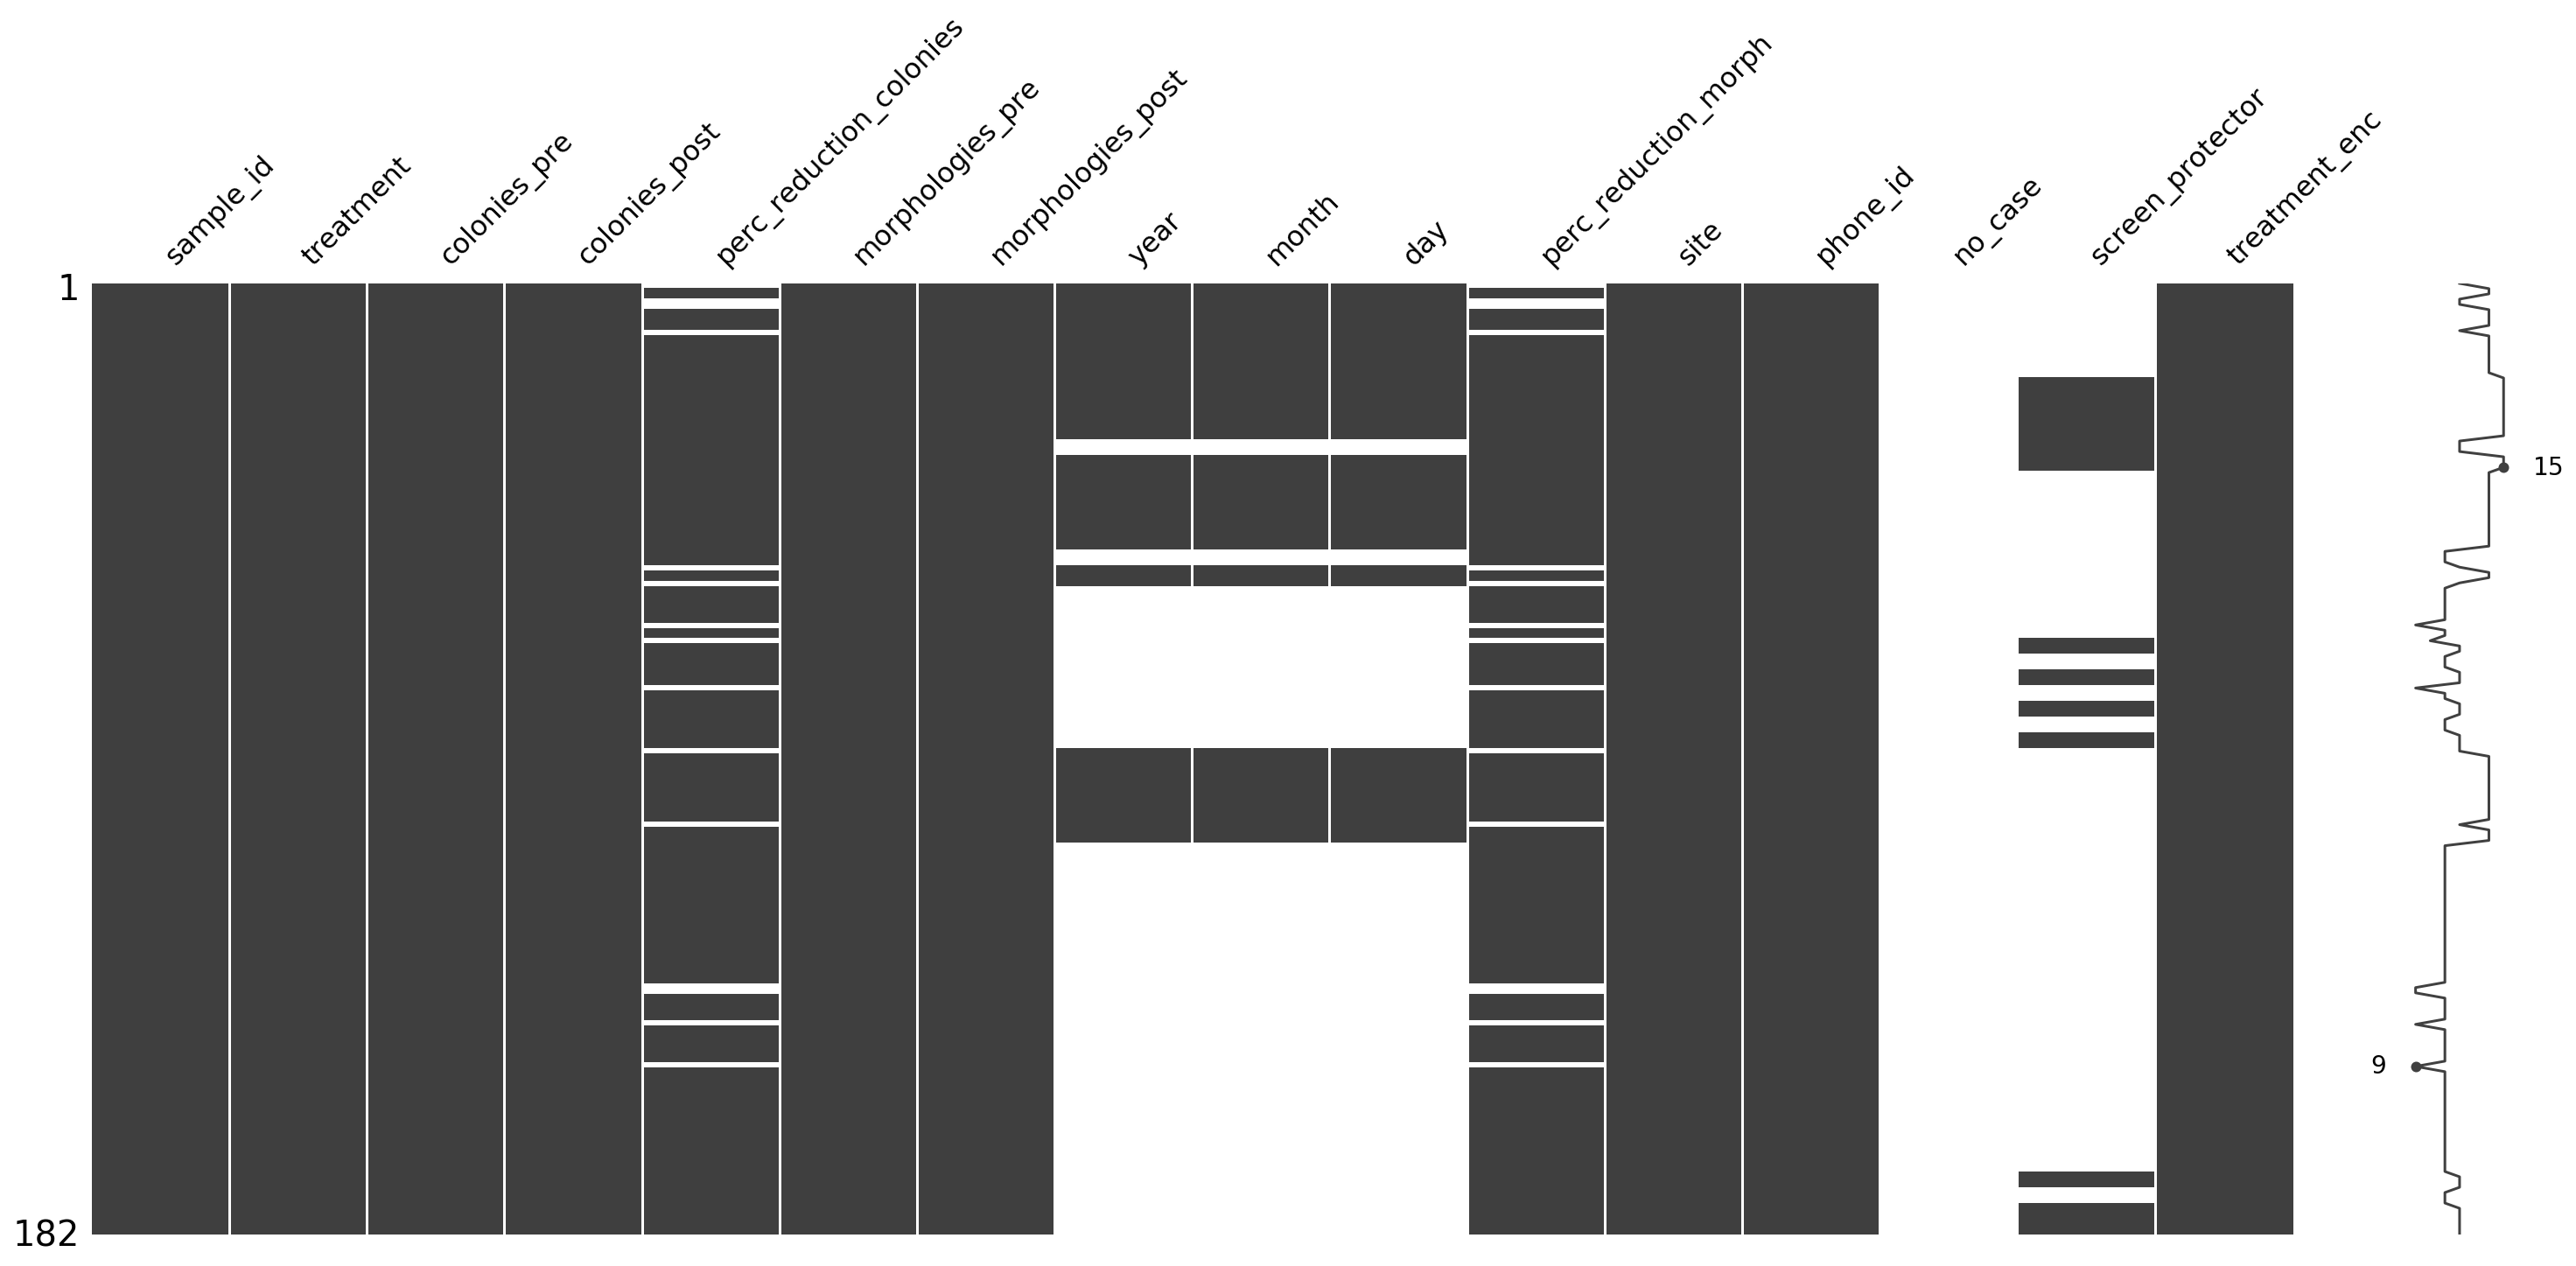

In [5]:
# Run this cell, no coding required.
msno.matrix(df)

**Exercise:** Plot the average percentage reduction in colonies for each treatment.

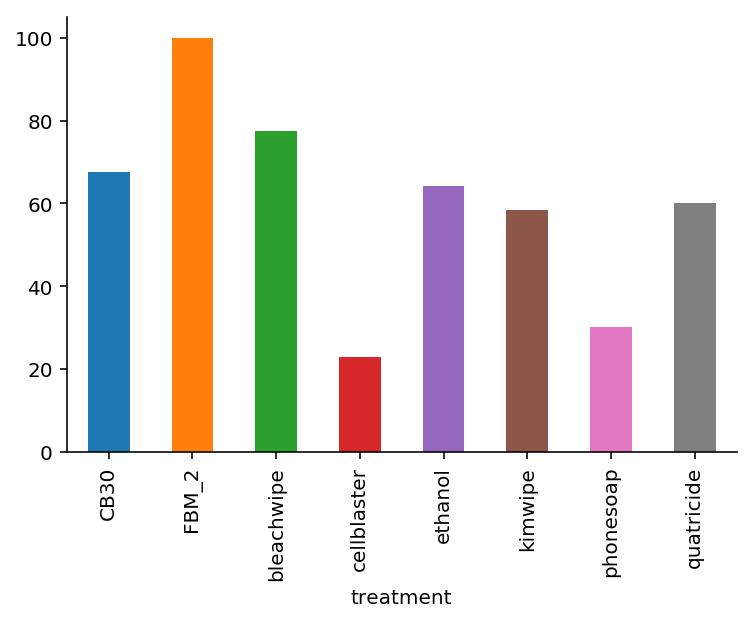

In [6]:
# Write your code here.
df.groupby('treatment').mean()['perc_reduction_colonies'].plot(kind='bar')

### Step 3: Implement and Fit Model

**Exercise:** Write the generative model for the data. 

To help you, this is a diagrammed version of the model below.

![](../images/bacteria_model.jpg)

In [7]:
# Implement the model following the hints provided.
with pm.Model() as model:
    
    # Define an exponential distribution: it is positive-only, which fits our assumptions of the
    # data. Also, we choose a lam parameter that allows the prior to be flat.
    # Remember that there are 8 treatments, so the shape of these distributions must be set correctly.
    mu_pre = pm.Exponential('mu_pre', lam=5, shape=len(df['treatment'].unique()))
    mu_post = pm.Exponential('mu_post', lam=5, shape=len(df['treatment'].unique()))
    
    # Define the likelihoods using Poisson distributions.
    like_pre = pm.Poisson('like_pre', mu=mu_pre[df['treatment_enc']], observed=df['colonies_pre'])
    like_post = pm.Poisson('like_post', mu=mu_post[df['treatment_enc']], observed=df['colonies_post'])
    
    # Compute percentage reduction
    # hint: tt.clip performs the exact same operation as 
    # np.clip, which bounds your values between 0 and 1.
    perc_reduction = pm.Deterministic('perc_reduction', tt.clip((mu_pre - mu_post) / mu_pre, 0, 1))

/home/ericmjl/anaconda/envs/bayesian-modelling-tutorial/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/ericmjl/anaconda/envs/bayesian-modelling-tutorial/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


Now, sample from the posterior!

In [8]:
with model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/ericmjl/anaconda/envs/bayesian-modelling-tutorial/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_post, mu_pre]
Sampling 4 chains:   0%|          | 0/10000 [00:00<?, ?draws/s]/home/ericmjl/anaconda/envs/bayesian-modelling-tutorial/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an er

Check the traces to make sure that sampling has converged.

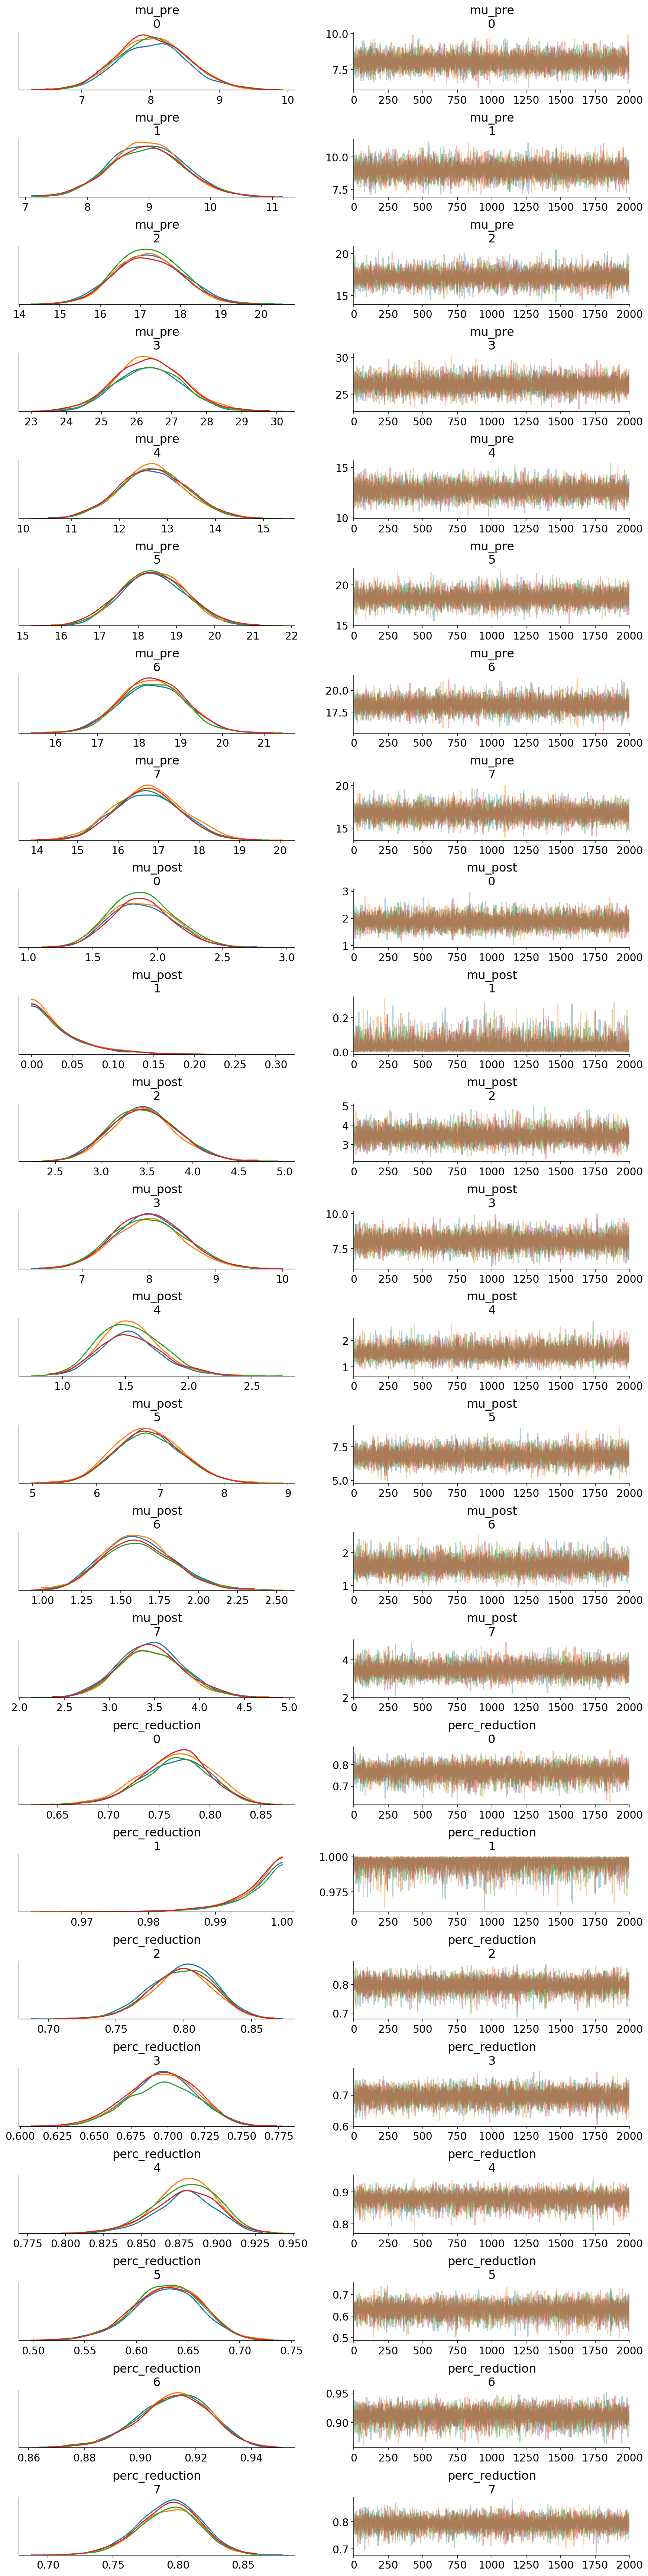

In [11]:
# Plot the trace plots.
traces = az.plot_trace(trace)

Visualize the posterior distributions of percentage reduction

(<Figure size 432x518.4 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f873a7965c0>],
       dtype=object))

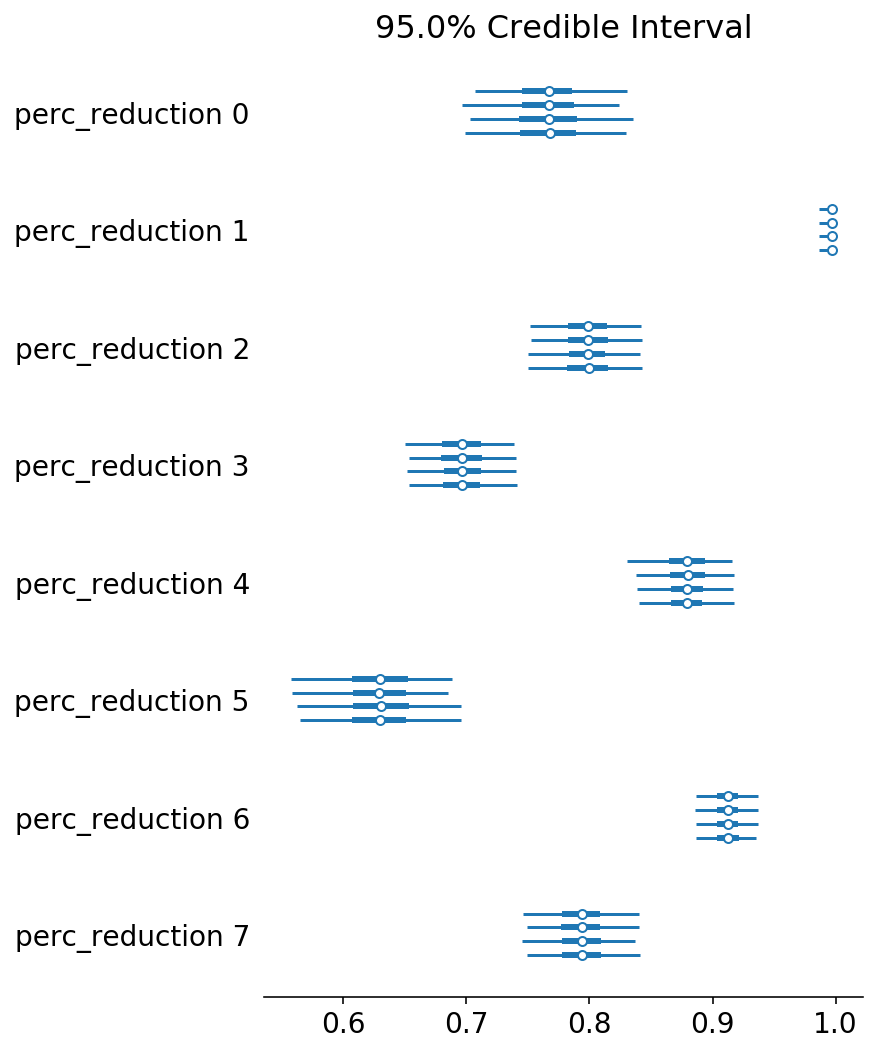

In [14]:
# Use the `plot_forest` or `plot_posterior` functions.
az.plot_forest(trace, var_names=['perc_reduction'], credible_interval=0.95)

**Discussion:** Find a neighbour who is working on the same notebook, and discuss this together.

- Which method of sterilization is the most effective? 
- Observe the posterior distribution. Is there any uncertainty surrounding this method's effectiveness? Could we still be wrong about the uncertainty?

# Summary

- Two-group (and multi-group) comparisons involve a Bayesian estimation procedure.
- We estimate parameter of interest for each group, and then compare the parameter posterior distributions.